In [ ]:
def image_preprocessing(img, target_resize_w,target_resize_h  ):
    kernel = np.ones((2,2))
    
    resize_im = img.resize((target_resize_w,target_resize_h))
    scale_img =  np.array(resize_im)/255
    dilate_img = cv2.dilate(scale_img,kernel = kernel)
    
    return dilate_img

# 準備資料：直接將將label的的bonding box 範圍資料切下範圍資料切下 (cropping)

In [ ]:
# training data
import os
from PIL import Image
import xml.etree.cElementTree as ET
import numpy as np
# prepare data
import cv2
def gen_data(img_dirs, label_map):
    X = []
    y = []
    kernel = np.ones((2,2))
    for dr in img_dirs:
        for f in os.listdir(dr):
            if f.endswith('.jpg'):
                im = Image.open(os.path.join(dr, f)).convert('L')

                # bbox
                xmlfile = os.path.join(dr, f[:-4]+'.xml')
                tree = ET.ElementTree(file=xmlfile)
                rt = tree.getroot()
                xmin = int(rt[6][4][0].text)
                ymin = int(rt[6][4][1].text)
                xmax = int(rt[6][4][2].text)
                ymax = int(rt[6][4][3].text)

                crop_im = im.crop((xmin, ymin, xmax, ymax))
                resize_im = crop_im.resize((target_resize_w,target_resize_h))
                img =  np.array(resize_im)/255
                img = cv2.dilate(img,kernel = kernel)
               
                X.append(img)
                y.append(label_map[rt[6][0].text])
            
    
    yy = []
    XX = []
    for i in range(len(y)):
        if y[i]< 2:
            yy.append(y[i])
            XX.append(X[i])
       
    y = np.array(yy)
    X= np.array(XX)
   
    
    return X, y

target_resize_w = 64
target_resize_h = 64

label_map = {'misaligned':0,
            'aligned':1,
            'not_sure':2}


train_img_dirs = ['.train' ]
valid_img_dirs = ['.test']


In [ ]:
X_train, y_train = gen_data(train_img_dirs, label_map)
X_valid, y_valid = gen_data(valid_img_dirs, label_map)


In [ ]:
def data_augmentation(im_array ,  color_mode,  aug_times):
    from imgaug import augmenters as iaa
    import imgaug as ia
    from scipy import misc
    
    im = np.asarray(im_array)
    ima = np.uint8(np.asarray(im_array))
 
    ia.seed(4)
    rotate = iaa.Affine(rotate=(-5, 5))
    
    #print(ima.shape)
    if color_mode == 'L':
        ima = ima.reshape(ima.shape[0], ima.shape[1])
        im = Image.fromarray(ima, 'L')
    else:
        ima = ima.reshape(ima.shape[0], ima.shape[1],3)
        im = Image.fromarray(ima,color_mode)
        
   

    images = [ima]*aug_times
    
    
    seq = iaa.Sequential([
        
        iaa.Crop(percent=(0, 0.05)), # random crops
        
        iaa.ContrastNormalization((0.95, 1.5)),
        
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        
        iaa.Multiply((0.9, 1.1), per_channel=0.2),
        
        iaa.Affine(
            scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-3, 3),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order

    images_aug = seq(images=images)

    return images_aug

In [ ]:
def make_pair_target_domain(images2, labels2, oxrate = 5, l0 = 0, l1 = 1):

   
    idx0 = np.where(labels2==l0)[0]     
    idx1 = np.where(labels2==l1)[0]
   

    pairImages2 = []
    pairLabels2 = []

    # positive pairs of OK
    npos = 0
    nneg = 0
    for idxA in idx1:
        currentImage = images2[idxA]
        label = labels2[idxA]
       
        for idxB in idx1:
            for i in range(6):
                posImage = images2[idxB]
                pairImages2.append([currentImage, posImage])
                pairLabels2.append([1])
                npos +=1
        
 
    for idxA in idx0:
        currentImage = images2[idxA]
        label = labels2[idxA]
         
         
        for idxB in idx1: 
            negImage = images2[idxB]            
            pairImages2.append([currentImage, negImage])
            pairLabels2.append([0])
            nneg += 1
        
    
        
    ridx = np.arange(len(pairImages2))
    print(ridx)
    ridx = np.random.permutation(ridx)
    print(ridx)
    pairImages2 = np.array(pairImages2)
    pairLabels2 = np.array(pairLabels2)
    pairImages2 = pairImages2[ridx,:,:]
    pairLabels2 = pairLabels2[ridx]
        
    return (pairImages2, pairLabels2)

(pairImagesTrain, pairLabelsTrain)=make_pair_target_domain(X_train, y_train)
(pairImagesValid, pairLabelsValid)=make_pair_target_domain(X_valid, y_valid) 


# 觀察配對資料

168


/home/julia/venv/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


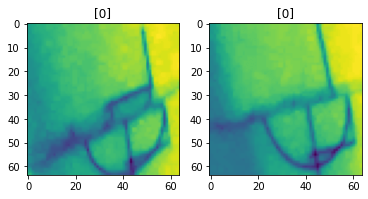

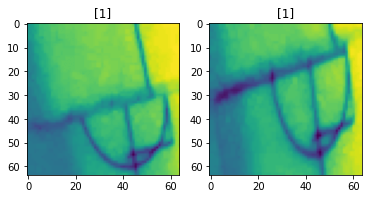

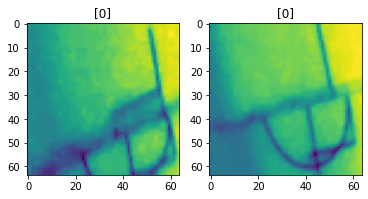

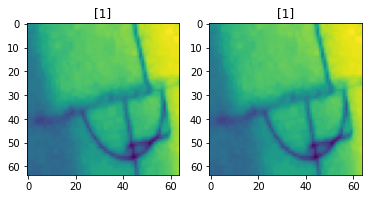

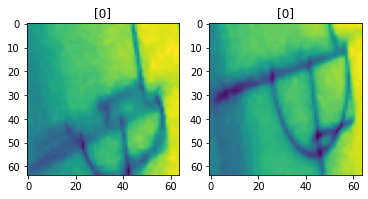

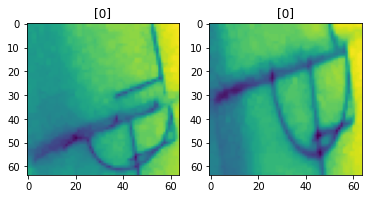

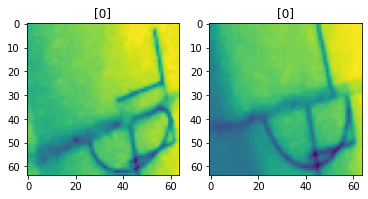

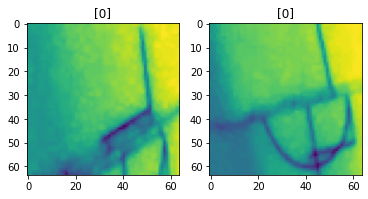

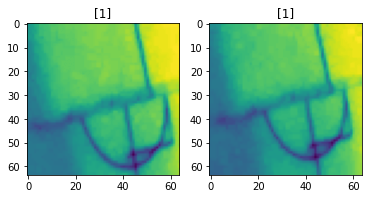

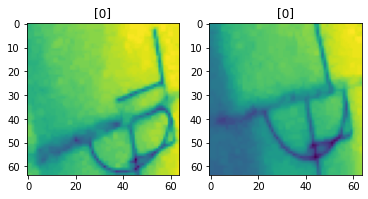

In [ ]:

import matplotlib.pyplot as plt
for ix in range(10):
    plt.subplot(1,2,1), plt.imshow(pairImagesTrain[ix][0]), plt.title(pairLabelsTrain[ix])
    plt.subplot(1,2,2), plt.imshow(pairImagesTrain[ix][1]), plt.title(pairLabelsTrain[ix])
    plt.show()
 

# build the siemse network

In [ ]:
# build the siemse network
IMG_SHAPE = (64, 64, 1)
BATCH_SIZE = 64
EPOCHS = 50
BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.backend as K

def build_siamese_model(inputShape, embeddingDim=48):
    kernel_size = [3]*5
    feature_map = [32,32,64,64,128,128]
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    
    x = Conv2D(feature_map[0], (kernel_size[0], kernel_size[0]), activation='relu', padding='same',data_format = 'channels_last', name = 'layer0_conv2d')(inputs) 
    x = MaxPooling2D((2, 2), padding='same', name = 'layer0_maxpool')(x)

    for i in range(1, len(kernel_size)):
        
        x = Conv2D(feature_map[i], (kernel_size[i], kernel_size[i]), activation='relu', padding='same' ,data_format = 'channels_last',  name = 'layer' + str(i) +'_conv2d')(x) 
        x = Conv2D(feature_map[i], (kernel_size[i], kernel_size[i]), activation='relu', padding='same' ,data_format = 'channels_last',  name = 'layer' + str(i) +'_conv2d_2')(x) 
        x = MaxPooling2D((2, 2), padding='same', name = 'layer' +str(i) +'_maxpool')(x)



    outputs = GlobalAveragePooling2D(name = 'avg_pooling_layer')(x) 
  
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


import tensorflow.keras.backend as K 
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    contrastive_loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return  contrastive_loss

In [ ]:
def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape= IMG_SHAPE)
imgB = Input(shape= IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1)(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

model.summary()

[INFO] building siamese network...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          369536      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0   

In [ ]:
# compile the model

BATCH_SIZE = 32
EPOCHS  = 100
import tensorflow as tf
print("[INFO] compiling model...")
#model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
 
model.compile(loss=contrastive_loss, optimizer="adam")
 
# train the model
print("[INFO] training model...")
history = model.fit(
    [pairImagesTrain[:, 0], pairImagesTrain[:, 1]], pairLabelsTrain[:],
    validation_data=([pairImagesValid[:, 0], pairImagesValid[:, 1]], pairLabelsValid[:]),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS)


[INFO] compiling model...
[INFO] training model...
Epoch 1/100
6/6 [==============================] - 2s 122ms/step - loss: 0.6194 - val_loss: 0.1001
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 0.2893 - val_loss: 0.3915
Epoch 3/100
6/6 [==============================] - 0s 20ms/step - loss: 0.3578 - val_loss: 0.0824
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 0.2539 - val_loss: 0.0985
Epoch 5/100
6/6 [==============================] - 0s 20ms/step - loss: 0.1682 - val_loss: 0.0782
Epoch 6/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1004 - val_loss: 0.0436
Epoch 7/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0387 - val_loss: 0.0293
Epoch 8/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0198 - val_loss: 0.0272
Epoch 9/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0138 - val_loss: 0.0293
Epoch 10/100
6/6 [==============================] - 0s 21ms/step -

6/6 [==============================] - 0s 20ms/step - loss: 8.0558e-05 - val_loss: 0.0714
Epoch 82/100
6/6 [==============================] - 0s 21ms/step - loss: 5.3844e-05 - val_loss: 0.0700
Epoch 83/100
6/6 [==============================] - 0s 21ms/step - loss: 7.4117e-05 - val_loss: 0.0719
Epoch 84/100
6/6 [==============================] - 0s 21ms/step - loss: 4.4311e-05 - val_loss: 0.0722
Epoch 85/100
6/6 [==============================] - 0s 21ms/step - loss: 3.4497e-05 - val_loss: 0.0701
Epoch 86/100
6/6 [==============================] - 0s 21ms/step - loss: 4.9481e-05 - val_loss: 0.0717
Epoch 87/100
6/6 [==============================] - 0s 19ms/step - loss: 1.4624e-04 - val_loss: 0.0738
Epoch 88/100
6/6 [==============================] - 0s 21ms/step - loss: 6.7188e-05 - val_loss: 0.0726
Epoch 89/100
6/6 [==============================] - 0s 20ms/step - loss: 2.9295e-05 - val_loss: 0.0715
Epoch 90/100
6/6 [==============================] - 0s 21ms/step - loss: 1.7482e-05 - 

In [ ]:
yp = model.predict([pairImagesValid[:, 0], pairImagesValid[:, 1]])

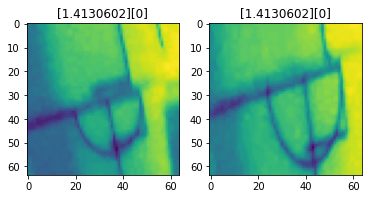

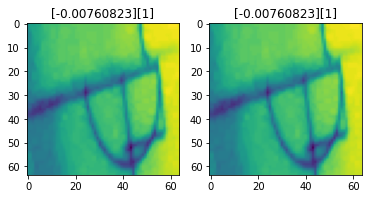

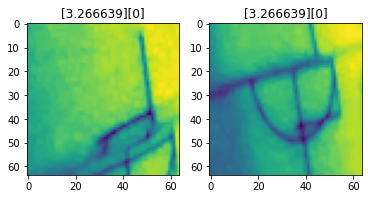

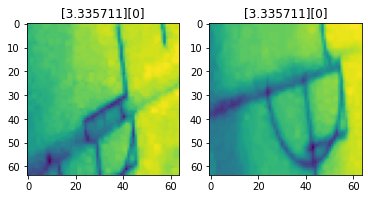

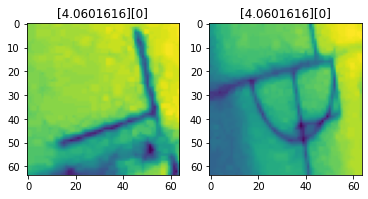

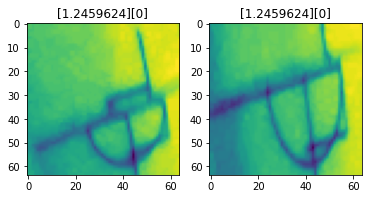

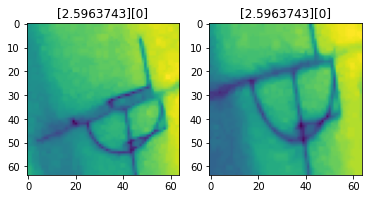

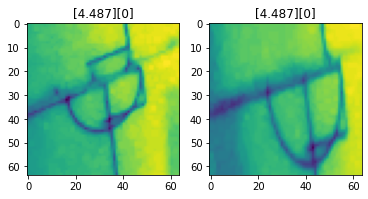

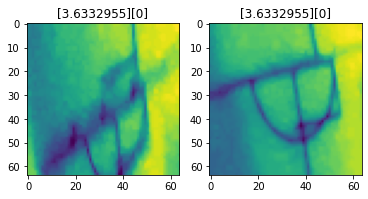

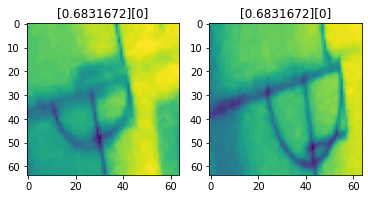

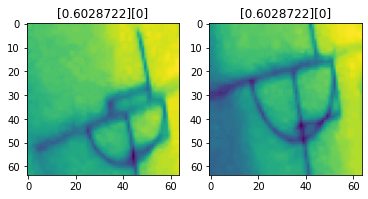

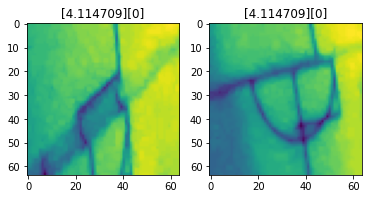

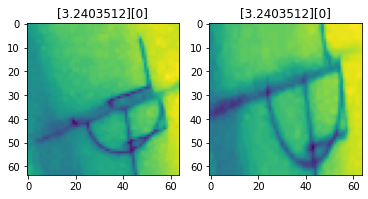

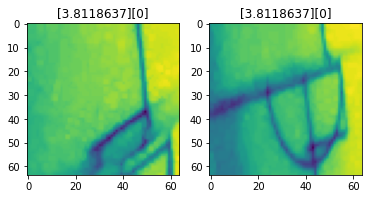

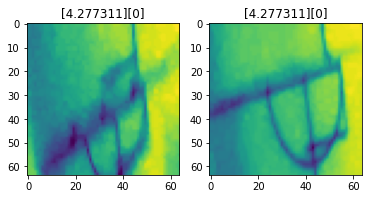

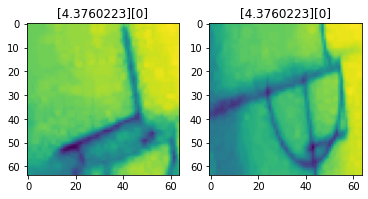

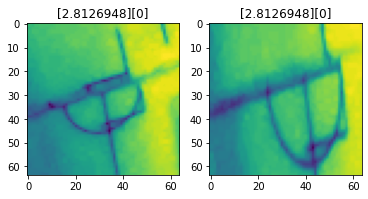

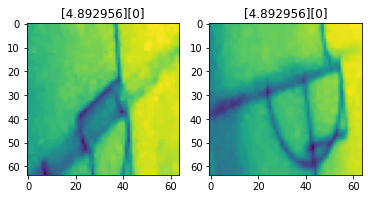

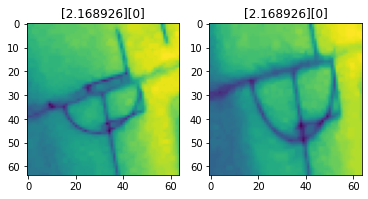

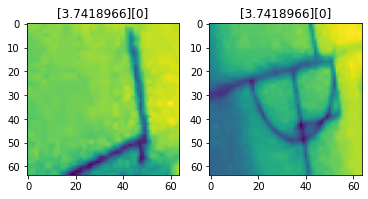

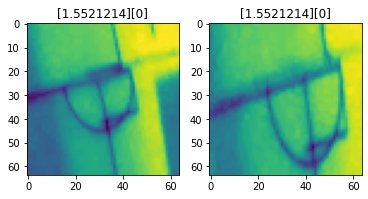

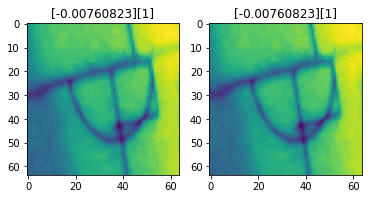

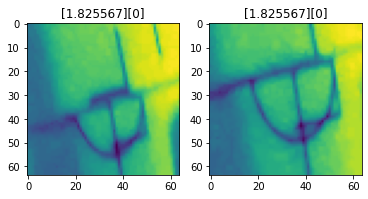

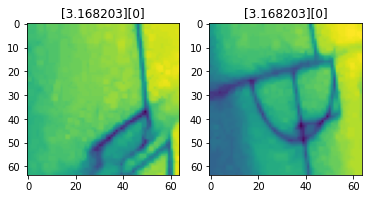

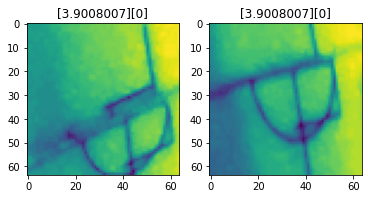

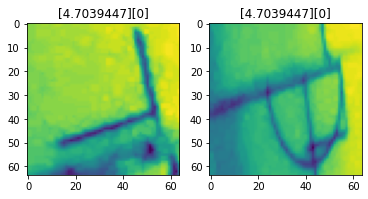

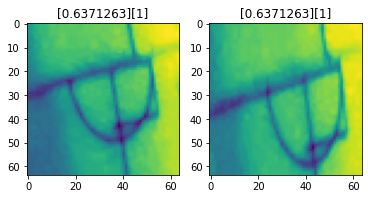

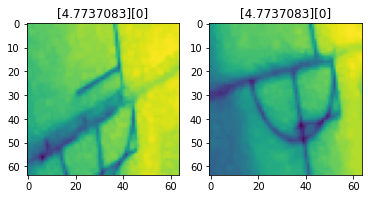

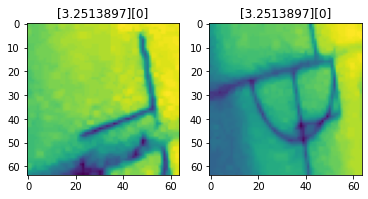

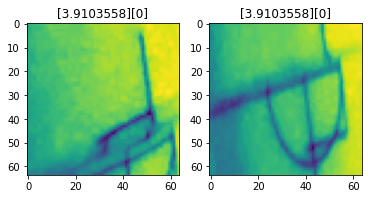

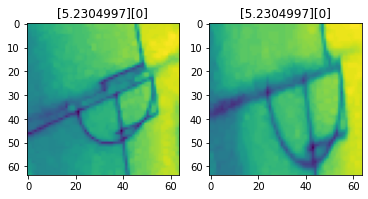

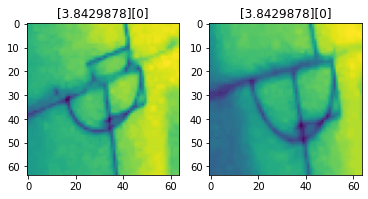

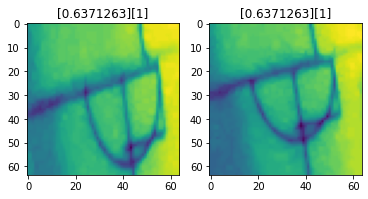

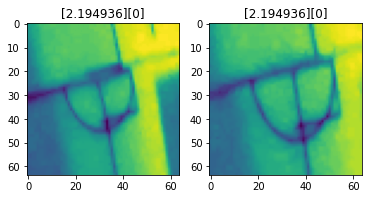

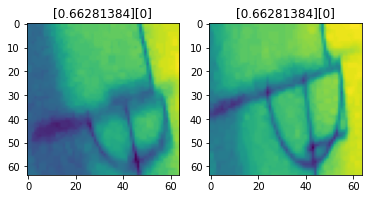

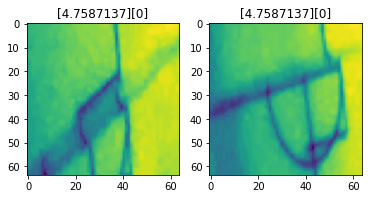

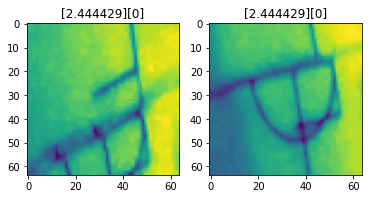

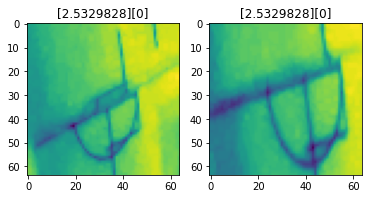

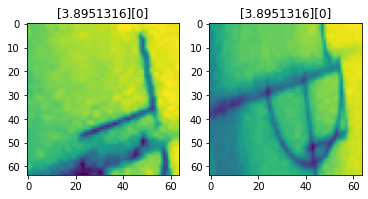

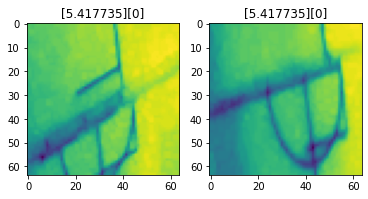

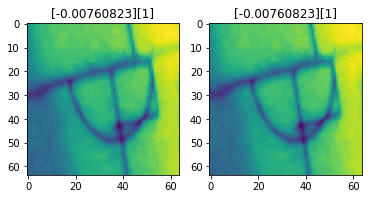

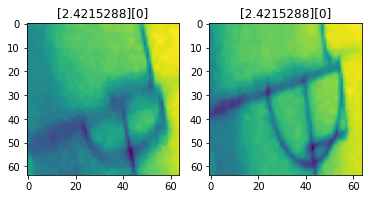

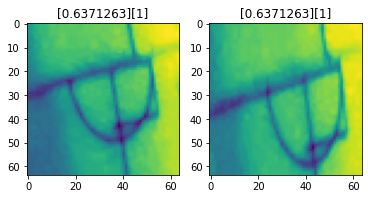

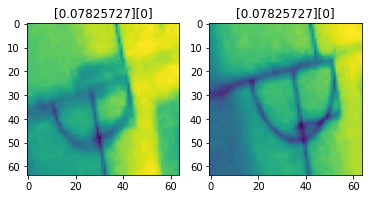

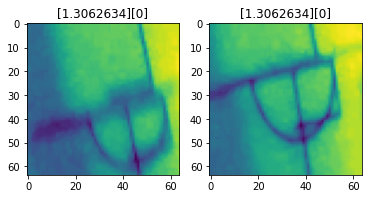

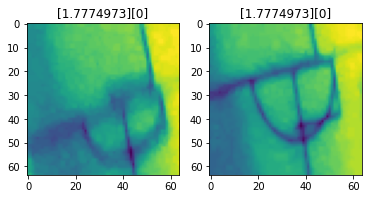

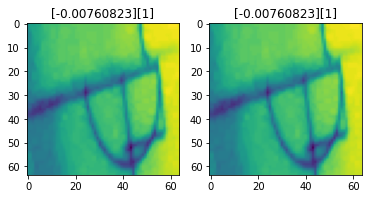

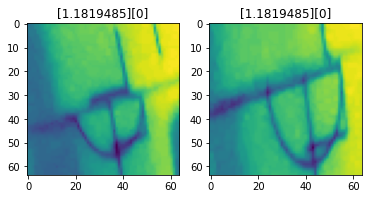

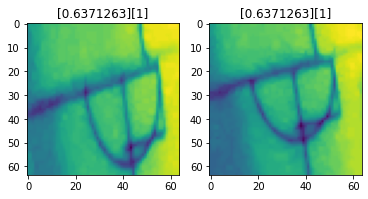

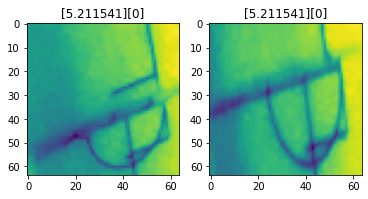

In [ ]:

for ix  in range(50):
    plt.subplot(1,2,1), plt.imshow(pairImagesValid[ix][0]), plt.title(str(yp[ix])+str(pairLabelsValid[ix]) )
    plt.subplot(1,2,2), plt.imshow(pairImagesValid[ix][1]), plt.title(str(yp[ix])+str(pairLabelsValid[ix]) )
    plt.show()


In [ ]:
model.save('siamese_model_1019_3')
model.save('siamese_model_1019_3.hdf5')

INFO:tensorflow:Assets written to: siamese_model_1019_3/assets


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121]
[110 103  10  75  24  51  18  94  84  45  52 111 112  26   0  57  23 105
  50 100  67  69 116  28 107  46  37  65  39 117  81  54  17  93  34  33
  88 102 109  15 104  53  19   7  55  56  87  72 119   9  16  59  35  38
  80  78  40  43  42  85  63  70 121  44  99   2  14 115  36  22   5  74
  68  66  90  12  30  83  79  61 101 106   4  92  73  21 113 118  64 108
  82  20  31  11  49  27 120  48   3  96  58  98  95   6 114  32  13  41
  76  25  60  86  62  47   8  71  97  29  91  77  89   1]


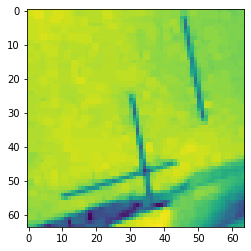

In [ ]:
# test on unseen data


test_dir0 = 'dataset2/valid_crop_2class/misaligned'
test_dir1 = 'dataset2/valid_crop_2class/marker'

images = []
labels = []
for f in os.listdir(test_dir0):
    im = Image.open(os.path.join(test_dir0, f)).convert('L')  
    img = image_preprocessing(im,target_resize_w,target_resize_h )                
    images.append(img)
    labels.append(0)
    
for f in os.listdir(test_dir1):
    
    im = Image.open(os.path.join(test_dir1, f)).convert('L')  
    img = image_preprocessing(im,target_resize_w,target_resize_h )                
    images.append(img)
    labels.append(1)
plt.imshow(images[0])  

images = np.array(images)
labels = np.array(labels)
#print(labels)
#print(np.where(labels == 1)[0])
(pairImagesTest, pairLabelsTest)=make_pair_target_domain(images, labels)
   



In [ ]:
yp2 = model.predict([pairImagesTest[:, 0], pairImagesTest[:, 1]])

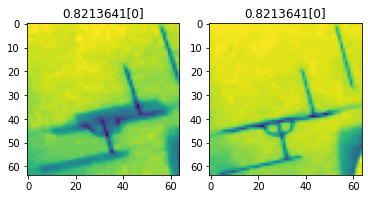

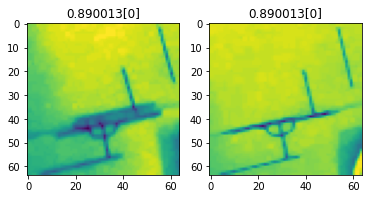

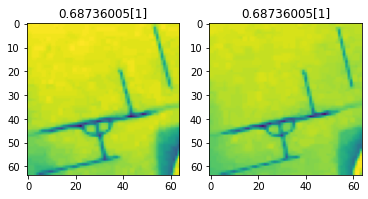

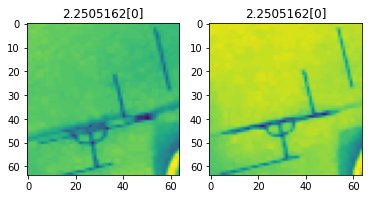

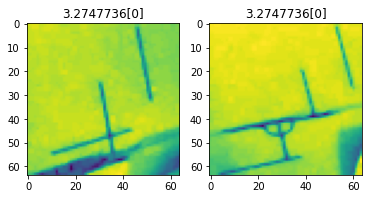

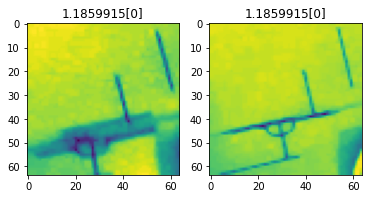

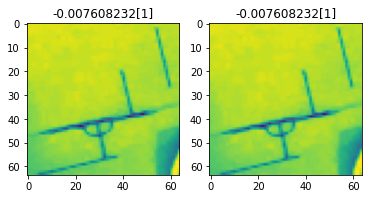

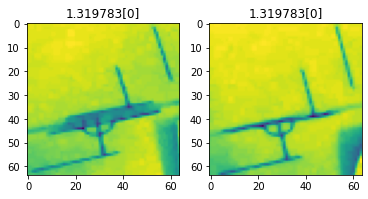

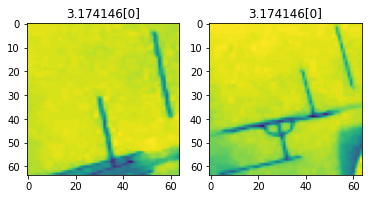

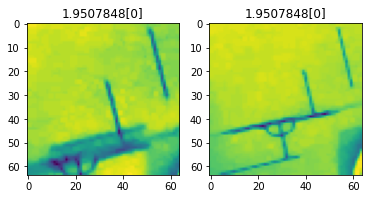

In [ ]:
pairImg = pairImagesTest
pairlable = pairLabelsTest
for ix  in range(10):
    plt.subplot(1,2,1), plt.imshow(pairImg[ix][0]), plt.title(str(yp2[ix][0])+str(pairlable[ix]) )
    plt.subplot(1,2,2), plt.imshow(pairImg[ix][1]), plt.title(str(yp2[ix][0])+str(pairlable[ix]) )
    plt.show()

[0.01582613 0.2786854  0.5415447  0.80440396 1.0672632  1.3301225
 1.5929818  1.855841   2.1187003  2.3815596  2.644419   2.9072783
 3.1701374  3.4329967  3.695856   3.9587152  4.221575   4.4844337
 4.747293   5.0101523  5.2730117 ]
[ 6  6  8 11  7  8  8  9  5  8  4  3  4  3  0  1  2  3  0  2]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6919e65d68>,
 (array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]),
  array([-0.00760823,  0.06188859,  0.13138543,  0.20088226,  0.27037907,
          0.3398759 ,  0.40937275,  0.47886956,  0.54836637,  0.61786324,
          0.68736005], dtype=float32),
  <a list of 10 Patch objects>))

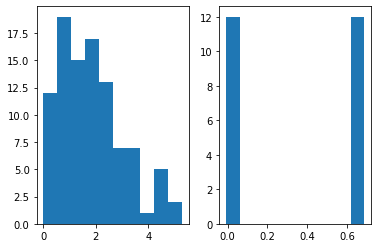

In [ ]:
idx0 = np.where(pairlable==0)[0]
idx1 = np.where(pairlable==1)[0]
hist0, i0 = np.histogram(yp2[idx0],20)
hist1, i1 = np.histogram(yp2[idx1],20)

print(i0)
print(hist0)
plt.subplot(1,2,1), plt.hist(yp2[idx0])
plt.subplot(1,2,2), plt.hist(yp2[idx1])

In [ ]:
# finetune
from tensorflow.keras.models import load_model
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    contrastive_loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return  contrastive_loss

model2 = load_model('siamese_model_1019_2.hdf5', custom_objects={ 'contrastive_loss': contrastive_loss })
#model2 = load_model('siamese_model_1019_2', custom_objects={ 'loss': contrastive_loss(y, preds, margin=1) },compile=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[22 31 15  6 18 25 26  4 34 28 12 23  5 11  3 17 20 27 30 32  8 16 14  7
  9  1 35  2  0 24 19 10 21 33 29 13]


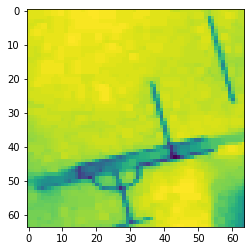

In [ ]:
dir0 = 'dataset2/train_crop_2class/misaligned'
dir1 = 'dataset2/train_crop_2class/marker'

images = []
labels = []
for f in os.listdir(dir0):
    im = Image.open(os.path.join(dir0, f)).convert('L')  
    img = image_preprocessing(im,target_resize_w,target_resize_h )                
    images.append(img)
    labels.append(0)
    
for f in os.listdir(dir1):
    
    im = Image.open(os.path.join(dir1, f)).convert('L')  
    img = image_preprocessing(im,target_resize_w,target_resize_h )                
    images.append(img)
    labels.append(1)
plt.imshow(images[0])  

images = np.array(images)
labels = np.array(labels)
#print(labels)
#print(np.where(labels == 1)[0])
(pairImagesTrain2, pairLabelsTrain2)=make_pair_target_domain(images, labels)

In [ ]:
len(pairImagesTrain2)

In [ ]:
history = model2.fit(
    [pairImagesTrain2[:, 0], pairImagesTrain2[:, 1]], pairLabelsTrain2[:],
    #validation_data=([pairImagesValid[:, 0], pairImagesValid[:, 1]], pairLabelsValid[:]),
    batch_size=6, 
    epochs=3)

Epoch 1/3
6/6 [==============================] - 0s 12ms/step - loss: 3.3295e-04
Epoch 2/3
6/6 [==============================] - 0s 11ms/step - loss: 1.9690e-04
Epoch 3/3
6/6 [==============================] - 0s 9ms/step - loss: 7.1369e-05


In [ ]:
yp2_fine = model2.predict([pairImagesTest[:, 0], pairImagesTest[:, 1]])

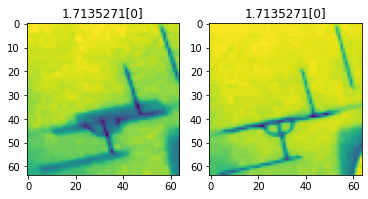

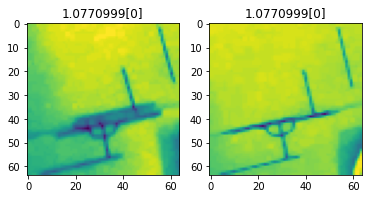

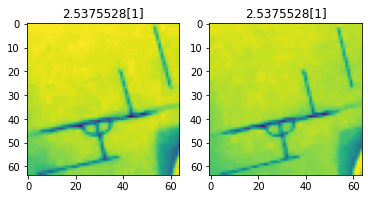

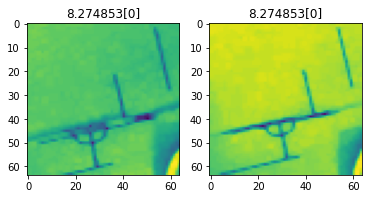

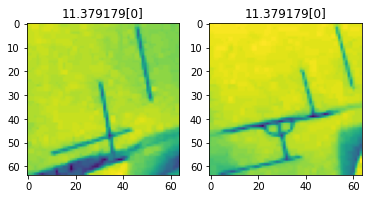

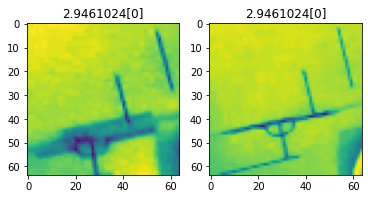

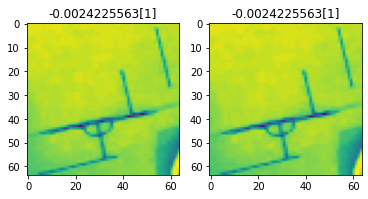

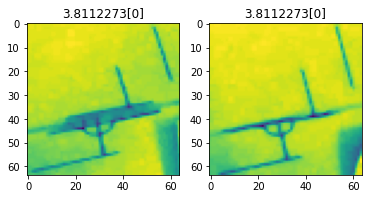

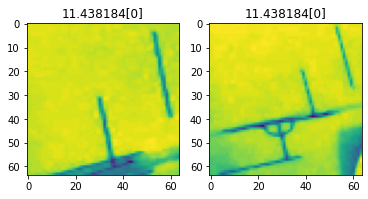

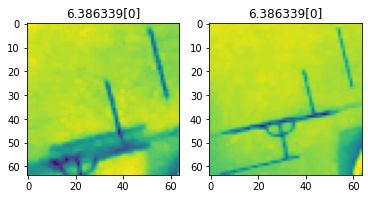

In [ ]:

for ix  in range(10):
    plt.subplot(1,2,1), plt.imshow(pairImg[ix][0]), plt.title(str(yp2_fine[ix][0])+str(pairlable[ix]) )
    plt.subplot(1,2,2), plt.imshow(pairImg[ix][1]), plt.title(str(yp2_fine[ix][0])+str(pairlable[ix]) )
    plt.show()

[ 0.4809625  1.3199588  2.158955   2.9979515  3.836948   4.6759443
  5.5149403  6.3539367  7.192933   8.031929   8.870926   9.709922
 10.548919  11.387915  12.226912  13.0659075 13.904903  14.7439
 15.582896  16.421892  17.26089  ]
[10  9 11  5  8 12  4  6  3  6  5  1  4  6  1  0  5  0  0  2]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f689020f550>,
 (array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]),
  array([-2.4225563e-03,  2.5157499e-01,  5.0557250e-01,  7.5957006e-01,
          1.0135676e+00,  1.2675651e+00,  1.5215627e+00,  1.7755603e+00,
          2.0295577e+00,  2.2835553e+00,  2.5375528e+00], dtype=float32),
  <a list of 10 Patch objects>))

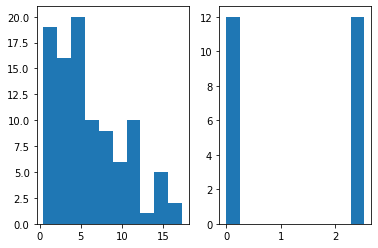

In [ ]:
idx0 = np.where(pairlable==0)[0]
idx1 = np.where(pairlable==1)[0]
hist0, i0 = np.histogram(yp2_fine[idx0],20)
hist1, i1 = np.histogram(yp2_fine[idx1],20)

print(i0)
print(hist0)
plt.subplot(1,2,1), plt.hist(yp2_fine[idx0])
plt.subplot(1,2,2), plt.hist(yp2_fine[idx1])